In [1]:
import numpy as np
from numpy.random import normal
import matplotlib.pyplot as plt
import math
import itertools
import CUDAPython as CP
from scipy.constants import hbar
%matplotlib inline

In [2]:
#sets number of levels (k) and number of fermions (m)
k = 10
m = 5

Generating single fermion energy levels:

In [3]:
def generate_energies(k):
    '''generates ordered array of k distinct energy levels'''
    energies = np.empty(k)
    count=0
    while(count!=k):
        energies[count]=normal(0,1) #samples a normal distribution k times
        count+=1
    min_ar = np.min(energies) #minimum of energies to use for scaling
    scaled_ar = energies + abs(min_ar) #scaled array is generated
    return np.sort(scaled_ar) #output is a scaled, sorted array of size k

In [4]:
arr = generate_energies(k)

Text(0, 0.5, 'Energy level')

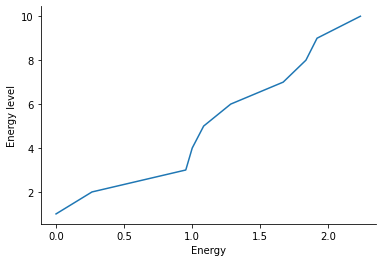

In [5]:
fig, axes = plt.subplots()
axes.plot(arr,np.linspace(1,k,k))
axes.spines['top'].set_color('none')
axes.spines['right'].set_color('none')
axes.set_xlabel('Energy')
axes.set_ylabel('Energy level')

Considering m fermions on k single fermion energy levels:

In [6]:
def size(k, m):
    '''determines the number of combination of m fermions on k energy levels'''
    return int(math.factorial(k)/((math.factorial(k-m))*(math.factorial(m))))

In [7]:
def ground_state(k, m):
    '''initialises a ground state based on number of fermions (m) and number of energy levels (k)
    
    e.g. for k=10, m=5:
    ground state is [1,1,1,1,1,0,0,0,0,0]'''
    state = np.zeros(k, dtype=int)
    for i in range(m):
        state[i] = 1
    return state

In [8]:
def permutations(state):
    '''returns a list of possible permutations of a given binary state'''
    return list(set(itertools.permutations(state)))    

In [9]:
state = ground_state(k, m) #initialises ground state

In [10]:
state

array([1, 1, 1, 1, 1, 0, 0, 0, 0, 0])

In [11]:
states = permutations(state) #list of possible permutations of the ground state

In [12]:
energy_state = {} #empty dict for mapping energies to their corresponding state {energy: state}
energies = np.empty(size(k,m))

In [13]:
for state in range(len(states)): #looping through all possible states
    energy = np.dot(states[state],arr) #computes energy of a given state via a dot product; energy and state arrays can be thought of as vectors -> dot product
    energies[state] = energy
    energy_state[energy] = states[state] #mapping the energy to its given state

In [14]:
sorted_energies = np.sort(energies) #sorting the energies in ascending order

In [15]:
sorted_dict = {} #empty dict to be used in mapping SORTED energies to their states (useful later)

In [16]:
for energy in sorted_energies:
    sorted_dict[energy] = energy_state[energy] #mapping sorted energies to their corresponding states

Text(0, 0.5, 'Energy eigenvalues')

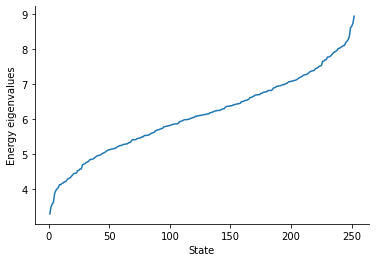

In [17]:
fig, axes = plt.subplots()
axes.plot(np.linspace(1,size(k,m),size(k,m)),sorted_energies)
axes.spines['top'].set_color('none')
axes.spines['right'].set_color('none')
axes.set_xlabel('State')
axes.set_ylabel('Energy eigenvalues')

In [18]:
H_0 = np.zeros((size(k,m),size(k,m))) #generating a zero matrix which has dimensions of the number of permutations of the initial state

In [19]:
for i in range(size(k,m)):
    H_0[i][i] = sorted_energies[i] #filling the diagonals with the energy eigenvalues

In [20]:
w = np.empty((size(k,m),size(k,m))) #generating an empty matrix with the same dimensions as H_0

In [21]:
for i in range(size(k,m)):
    for j in range(size(k,m)):
        w[i][j] = normal(0,1) #loops through all possible elements of w and samples a normal distribution

In [22]:
w_T = np.transpose(w) #determines the transpose of the matrix w

In [23]:
W = (w+w_T)/2 #ensuring that the random matrix W is real and symmetric

In [24]:
H = H_0 + W #H is the hamiltonian with interactions due to the random matrix (non-diagonal)

Diagonalisation of H:

In [25]:
hCUDA = CP.CUDAContext() #obtain CUDA context (only 1 needed)

hCUBLAS = CP.CUBLASContext() 
hCUBLAS.Create() #create CUBLAS context (for basic linear algebra ops)

hCUSolverDense = CP.CUSolverDenseContext()
hCUSolverDense.Create() #create CUSolver Context (for dense matrix ops)

In [26]:
#allocating memory on the CPU to fit a matrix of size size X size
hHostMatrix = CP.CUDAHostMemory()
hHostMatrix.Allocate2D(CP.CUDANumericSizeRD, size(k,m), size(k,m), CP.CUDAHostMemoryAllocFlags.PINNED)

hHostVector = CP.CUDAHostMemory()
hHostVector.Allocate1D(CP.CUDANumericSizeRD, size(k,m), CP.CUDAHostMemoryAllocFlags.PINNED)

In [27]:
for i in range(size(k,m)):
    for j in range(size(k,m)):
        hHostMatrix.WriteRD(CP.CUDAMemoryPosition(i,j,0), H[i][j]) #initialising values

In [28]:
#allocating memory on the GPU to fit a matrix of size size X size
hDeviceMatrixA = CP.CUDADeviceMemory()
hDeviceMatrixA.Allocate2D(CP.CUDANumericSizeRD, size(k,m), size(k,m))

hDeviceVectorX = CP.CUDADeviceMemory()
hDeviceVectorX.Allocate1D(CP.CUDANumericSizeRD, size(k,m))

In [29]:
hCUBLAS.SetMatrix(hDeviceMatrixA, CP.CUDAMemoryPosition(), hHostMatrix, CP.CUDAMemoryPosition(), CP.CUDAMemoryRegion(size(k,m),size(k,m),1)) #copy memory from CPU to GPU
hCUDA.WaitForCurrentDevice() #sync

In [30]:
#build and setup of solver
hEigenSolver = CP.CUSolverDenseEigenValue(hCUSolverDense)
hEigenSolver.SetMatrixA(hDeviceMatrixA)
hEigenSolver.SetMatrixFillModeA(CP.CUBLASContextFillMode.UPPER)
hEigenSolver.SetVectorX(hDeviceVectorX)
hEigenSolver.SetAlgorithm(CP.CUSolverDenseEigenValueAlgorithm.QR) #householder reduction method???
hEigenSolver.ComputeEigenVectors(True)

In [31]:
hEigenSolver.PrepareRD() #allocates workspace memory

In [32]:
#solve and sync
hEigenSolver.SolveRD()
hCUDA.WaitForCurrentDevice()
hEigenSolver.UpdateStateAfterSync()

In [33]:
#copy memory from GPU to CPU
hCUBLAS.GetMatrix(hHostMatrix, CP.CUDAMemoryPosition(), hDeviceMatrixA, CP.CUDAMemoryPosition(), CP.CUDAMemoryRegion(size(k,m), size(k,m), 1))
hCUDA.WaitForCurrentDevice()

hCUBLAS.GetVector(hHostVector, CP.CUDAMemoryPosition(), hDeviceVectorX, CP.CUDAMemoryPosition(), CP.CUDAMemoryRegion(size(k,m), 1, 1))
hCUDA.WaitForCurrentDevice()

In [34]:
hPos = CP.CUDAMemoryPosition()

In [35]:
D = np.zeros((size(k,m), size(k,m))) #initialising matrix to be used to store the eigenvalues as diagonal elements
P = np.zeros((size(k,m), size(k,m))) #initialising basis change matrix (H=PDP^-1)

In [36]:
for hPos.iX in range(size(k,m)):
    D[hPos.iX][hPos.iX] = hHostVector.ReadRD(hPos) #sets the diagonal elements of the matrix to the eigenvalues computed using the above algorithm

In [37]:
#need to prepare P matrix using the eigenvectors given by the above algorithm
for hPos.iY in range(size(k,m)):
    for hPos.iX in range(size(k,m)):
        P[hPos.iY][hPos.iX] = hHostMatrix.ReadRD(hPos)

In [38]:
P_T = np.transpose(P)

In [39]:
#free memory and destroy contexts
hDeviceVectorX.Free()
hDeviceMatrixA.Free()
hHostVector.Free()
hHostMatrix.Free()

hCUSolverDense.Destroy()
hCUBLAS.Destroy()

In [41]:
#need time evolution of the D matrix
def D_evo(t):
    '''Function that produces the D matrix for a given time t (time evolution of D matrix)'''
    D_ev = np.zeros((size(k,m), size(k,m)), dtype=complex)
    
    for x in range(size(k,m)):
        D_ev[x][x] = np.exp(-1j*D[x][x]*t/hbar) #calculates time evolution of the diagonal elements
    return D_ev

In [42]:
#evolution operator
def v_t(t):
    '''Evolution operator for a given time t'''
    
    hCUBLAS = CP.CUBLASContext()
    hCUBLAS.Create()
    
    hHostMatrix = CP.CUDAHostMemory()
    hHostMatrix.Allocate2D(CP.CUDANumericSizeCD, size(k,m), size(k,m), CP.CUDAHostMemoryAllocFlags.PINNED)
    
    pass

In [114]:
#matrix multiplication using CUDA is stored within the test folder
#had issues with converting CUDAComplex64 type back to default python dtype
#found that matmult using numpy was fast enough to be used (avoided the issue with the dtypes)

In [116]:
D_exp = D_evo(1) # evolution matrix for a test time t=1

In [125]:
left_mat = np.matmul(P, D_exp) #multiplying P*e^H

In [126]:
V_t = np.matmul(left_mat, P_T) #multiplying above by P_T

In [136]:
#need to map i to its corresponding state
i_state_map = {}
sorted_states = list(sorted_dict.values())

In [140]:
for i in range(size(k,m)):
    i_state_map[i] = sorted_states[i] #looping through all states and adding them to a dictionary i: state_i

In [142]:
#can determine what the i-th state is by running the line below (e.g. the ground state i=0:)
i_state_map[0]

(1, 1, 1, 1, 1, 0, 0, 0, 0, 0)

In [151]:
#extract the evolution of some initial state, in this example, will use a random state located at i=107
i_state_map[107]

(0, 1, 0, 1, 1, 0, 1, 0, 1, 0)

In [166]:
evol_state = V_t[107]

In [173]:
evol_state

array([ 0.1020002 +0.01405032j,  0.02366482-0.05418718j,
       -0.07302603+0.05302706j, -0.03622644-0.02436115j,
        0.02694645+0.03217137j,  0.0030958 -0.05358424j,
       -0.04204231-0.02517234j,  0.03995545-0.07142259j,
        0.02159891-0.00535595j, -0.02022204+0.03344525j,
       -0.06067271+0.02215706j,  0.02474552-0.00520561j,
        0.02128397+0.02131918j, -0.02361137+0.036986j  ,
        0.03079174-0.09704787j,  0.01019254+0.06695411j,
        0.00747599+0.00113359j,  0.00891727-0.00522452j,
       -0.06150178+0.03846958j,  0.09081588+0.02332973j,
        0.0751803 -0.07535349j, -0.00573995+0.00577885j,
        0.05618795+0.03362786j, -0.06710458-0.00050705j,
       -0.01980946+0.0026313j ,  0.0535132 -0.00648618j,
       -0.02998242-0.02628335j, -0.02194163-0.0297712j ,
        0.03558433+0.06168511j, -0.0077313 -0.02958209j,
        0.03873579+0.01011756j,  0.01540632-0.00526162j,
        0.06724932+0.05718741j,  0.0084794 +0.00681975j,
       -0.05293041+0.09635241j,